### Edgar Moises Hernandez-Gonzalez
#### 16/04/20-17/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x4
##### Data Augmentation
##### 5 ejecuciones independientes

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 17 22:18:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [4]:
x_train = pd.read_csv("Ventaneo-A04T.csv", header=None)
x_test = pd.read_csv("Ventaneo-A04E.csv", header=None)
y_train = pd.read_csv("EtiquetasVentaneo-A04T.csv", header=None)
y_test = pd.read_csv("EtiquetasVentaneo-A04E.csv", header=None)

In [5]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6048, 11000)
(6048, 11000)
(6048, 1)
(6048, 1)


In [6]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 6048
n_samples_test : 6048


In [7]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
#le = LabelEncoder().fit(y_train)
#y_train = le.transform(y_train)
#y_test = le.transform(y_test)

In [8]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [9]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (4, 264) #ancho, alto
  fs = 250
  datos = np.zeros((6048,264,4))
  temporal = np.zeros((528,2))
  for i in range(data.shape[0]): #6048 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*500:(j+1)*500]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [10]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


In [11]:
print(x_train.shape)
print(x_test.shape)

(6048, 264, 4)
(6048, 264, 4)


In [12]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

53.8289390805143
93.96386761158601
0.00013414131871820146
0.0001381846703413442
1.0146952755172398
1.0941751921182155


In [13]:
maximo = np.ceil(np.max(x_train))

#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= maximo
x_test /= maximo

In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9968322
1.7400717
2.4840983e-06
2.5589752e-06
0.018790642
0.020262498


In [15]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(6048, 264, 4, 1)
(6048, 264, 4, 1)


In [16]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [17]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Epoch 1/1000
 - 3s - loss: 1.3860 - accuracy: 0.2515 - val_loss: 1.3844 - val_accuracy: 0.2479
Epoch 2/1000
 - 2s - loss: 1.3848 - accuracy: 0.2588 - val_loss: 1.3824 - val_accuracy: 0.2497
Epoch 3/1000
 - 3s - loss: 1.3843 - accuracy: 0.2629 - val_loss: 1.3807 - val_accuracy: 0.2503
Epoch 4/1000
 - 3s - loss: 1.3831 - accuracy: 0.2703 - val_loss: 1.3788 - val_accuracy: 0.2495
Epoch 5/1000
 - 3s - loss: 1.3822 - accuracy: 0.2779 - val_loss: 1.3766 - val_accuracy: 0.2503
Epoch 6/1000
 - 2s - loss: 1.3811 - accuracy: 0.2677 - val_loss: 1.3742 - val_accuracy: 0.2518
Epoch 7/1000
 - 3s - loss: 1.3796 - accuracy: 0.2804 - val_loss: 1.3710 - val_accuracy: 0.2561
Epoch 8/1000
 - 3s - loss: 1.3785 - accuracy: 0.2793 - val_loss: 1.3677 - val_accuracy: 0.2665
Epoch 9/1000
 - 2s - loss: 1.3766 - accuracy: 0.2935 - val_loss: 1.3637 - val_accuracy: 0.2905
Epoch 10/1000
 - 2s - loss: 1.3740 - accuracy: 0.3070 - val_loss: 1.3590 - val_accuracy: 0.2976
Epoch 11/1000
 - 2s - loss: 1.3713 -

Epoch 87/1000
 - 3s - loss: 1.2113 - accuracy: 0.4681 - val_loss: 1.1993 - val_accuracy: 0.4514
Epoch 88/1000
 - 3s - loss: 1.2094 - accuracy: 0.4658 - val_loss: 1.1987 - val_accuracy: 0.4468
Epoch 89/1000
 - 3s - loss: 1.2079 - accuracy: 0.4610 - val_loss: 1.1984 - val_accuracy: 0.4521
Epoch 90/1000
 - 3s - loss: 1.2054 - accuracy: 0.4724 - val_loss: 1.2015 - val_accuracy: 0.4499
Epoch 91/1000
 - 3s - loss: 1.2080 - accuracy: 0.4636 - val_loss: 1.2004 - val_accuracy: 0.4507
Epoch 92/1000
 - 3s - loss: 1.2060 - accuracy: 0.4712 - val_loss: 1.2024 - val_accuracy: 0.4509
Epoch 93/1000
 - 3s - loss: 1.2046 - accuracy: 0.4699 - val_loss: 1.1991 - val_accuracy: 0.4466
Epoch 94/1000
 - 3s - loss: 1.1997 - accuracy: 0.4724 - val_loss: 1.1996 - val_accuracy: 0.4507
Epoch 95/1000
 - 3s - loss: 1.1993 - accuracy: 0.4717 - val_loss: 1.2009 - val_accuracy: 0.4468
Epoch 96/1000
 - 2s - loss: 1.1894 - accuracy: 0.4821 - val_loss: 1.1989 - val_accuracy: 0.4501
Epoch 97/1000
 - 3s - loss: 1.1989 - acc

Epoch 172/1000
 - 3s - loss: 1.0881 - accuracy: 0.5408 - val_loss: 1.2170 - val_accuracy: 0.4476
Epoch 173/1000
 - 3s - loss: 1.0883 - accuracy: 0.5354 - val_loss: 1.2162 - val_accuracy: 0.4504
Epoch 174/1000
 - 3s - loss: 1.0806 - accuracy: 0.5460 - val_loss: 1.2116 - val_accuracy: 0.4544
Epoch 175/1000
 - 3s - loss: 1.0895 - accuracy: 0.5397 - val_loss: 1.2149 - val_accuracy: 0.4502
Epoch 176/1000
 - 3s - loss: 1.0866 - accuracy: 0.5450 - val_loss: 1.2219 - val_accuracy: 0.4484
Epoch 177/1000
 - 3s - loss: 1.0906 - accuracy: 0.5446 - val_loss: 1.2166 - val_accuracy: 0.4502
Epoch 178/1000
 - 3s - loss: 1.0794 - accuracy: 0.5405 - val_loss: 1.2132 - val_accuracy: 0.4545
Epoch 179/1000
 - 3s - loss: 1.0802 - accuracy: 0.5430 - val_loss: 1.2143 - val_accuracy: 0.4516
Epoch 180/1000
 - 3s - loss: 1.0881 - accuracy: 0.5408 - val_loss: 1.2211 - val_accuracy: 0.4519
Epoch 181/1000
 - 3s - loss: 1.0830 - accuracy: 0.5438 - val_loss: 1.2216 - val_accuracy: 0.4540
Epoch 182/1000
 - 3s - loss: 1

Epoch 257/1000
 - 3s - loss: 0.9920 - accuracy: 0.5947 - val_loss: 1.2440 - val_accuracy: 0.4578
Epoch 258/1000
 - 3s - loss: 0.9999 - accuracy: 0.5807 - val_loss: 1.2456 - val_accuracy: 0.4585
Epoch 259/1000
 - 3s - loss: 0.9941 - accuracy: 0.5891 - val_loss: 1.2327 - val_accuracy: 0.4565
Epoch 260/1000
 - 3s - loss: 0.9896 - accuracy: 0.5840 - val_loss: 1.2468 - val_accuracy: 0.4575
Epoch 261/1000
 - 3s - loss: 0.9947 - accuracy: 0.5871 - val_loss: 1.2464 - val_accuracy: 0.4606
Epoch 262/1000
 - 3s - loss: 0.9924 - accuracy: 0.5827 - val_loss: 1.2521 - val_accuracy: 0.4565
Epoch 263/1000
 - 3s - loss: 0.9851 - accuracy: 0.5918 - val_loss: 1.2503 - val_accuracy: 0.4580
Epoch 264/1000
 - 3s - loss: 0.9910 - accuracy: 0.5995 - val_loss: 1.2534 - val_accuracy: 0.4595
Epoch 265/1000
 - 3s - loss: 0.9802 - accuracy: 0.5946 - val_loss: 1.2569 - val_accuracy: 0.4580
Epoch 266/1000
 - 3s - loss: 0.9859 - accuracy: 0.5939 - val_loss: 1.2572 - val_accuracy: 0.4549
Epoch 267/1000
 - 3s - loss: 0

Epoch 342/1000
 - 3s - loss: 0.9271 - accuracy: 0.6229 - val_loss: 1.2827 - val_accuracy: 0.4595
Epoch 343/1000
 - 3s - loss: 0.9119 - accuracy: 0.6328 - val_loss: 1.2804 - val_accuracy: 0.4597
Epoch 344/1000
 - 3s - loss: 0.9176 - accuracy: 0.6220 - val_loss: 1.2762 - val_accuracy: 0.4635
Epoch 345/1000
 - 3s - loss: 0.9199 - accuracy: 0.6290 - val_loss: 1.2820 - val_accuracy: 0.4598
Epoch 346/1000
 - 2s - loss: 0.9199 - accuracy: 0.6227 - val_loss: 1.2776 - val_accuracy: 0.4651
Epoch 347/1000
 - 1s - loss: 0.9096 - accuracy: 0.6300 - val_loss: 1.2751 - val_accuracy: 0.4615
Epoch 348/1000
 - 1s - loss: 0.9153 - accuracy: 0.6336 - val_loss: 1.2829 - val_accuracy: 0.4628
Epoch 349/1000
 - 1s - loss: 0.9122 - accuracy: 0.6291 - val_loss: 1.2906 - val_accuracy: 0.4640
Epoch 350/1000
 - 1s - loss: 0.9085 - accuracy: 0.6268 - val_loss: 1.2860 - val_accuracy: 0.4635
Epoch 351/1000
 - 1s - loss: 0.9070 - accuracy: 0.6283 - val_loss: 1.2832 - val_accuracy: 0.4610
Epoch 352/1000
 - 1s - loss: 0

Epoch 427/1000
 - 2s - loss: 0.8574 - accuracy: 0.6478 - val_loss: 1.3180 - val_accuracy: 0.4613
Epoch 428/1000
 - 2s - loss: 0.8447 - accuracy: 0.6663 - val_loss: 1.3330 - val_accuracy: 0.4615
Epoch 429/1000
 - 1s - loss: 0.8485 - accuracy: 0.6596 - val_loss: 1.3277 - val_accuracy: 0.4635
Epoch 430/1000
 - 2s - loss: 0.8446 - accuracy: 0.6572 - val_loss: 1.3395 - val_accuracy: 0.4645
Epoch 431/1000
 - 2s - loss: 0.8613 - accuracy: 0.6607 - val_loss: 1.3128 - val_accuracy: 0.4628
Epoch 432/1000
 - 2s - loss: 0.8447 - accuracy: 0.6612 - val_loss: 1.3384 - val_accuracy: 0.4605
Epoch 433/1000
 - 2s - loss: 0.8333 - accuracy: 0.6729 - val_loss: 1.3482 - val_accuracy: 0.4611
Epoch 434/1000
 - 2s - loss: 0.8434 - accuracy: 0.6591 - val_loss: 1.3329 - val_accuracy: 0.4608
Epoch 435/1000
 - 2s - loss: 0.8348 - accuracy: 0.6615 - val_loss: 1.3501 - val_accuracy: 0.4620
Epoch 436/1000
 - 2s - loss: 0.8388 - accuracy: 0.6648 - val_loss: 1.3256 - val_accuracy: 0.4618
Epoch 437/1000
 - 2s - loss: 0

Epoch 512/1000
 - 2s - loss: 0.7850 - accuracy: 0.6847 - val_loss: 1.3796 - val_accuracy: 0.4567
Epoch 513/1000
 - 2s - loss: 0.7713 - accuracy: 0.6954 - val_loss: 1.3923 - val_accuracy: 0.4557
Epoch 514/1000
 - 1s - loss: 0.7768 - accuracy: 0.6911 - val_loss: 1.3869 - val_accuracy: 0.4580
Epoch 515/1000
 - 1s - loss: 0.7789 - accuracy: 0.6797 - val_loss: 1.3859 - val_accuracy: 0.4582
Epoch 516/1000
 - 2s - loss: 0.7777 - accuracy: 0.6895 - val_loss: 1.3903 - val_accuracy: 0.4582
Epoch 517/1000
 - 2s - loss: 0.7774 - accuracy: 0.6956 - val_loss: 1.3790 - val_accuracy: 0.4552
Epoch 518/1000
 - 2s - loss: 0.7771 - accuracy: 0.6900 - val_loss: 1.3954 - val_accuracy: 0.4575
Epoch 519/1000
 - 2s - loss: 0.7848 - accuracy: 0.6849 - val_loss: 1.3789 - val_accuracy: 0.4575
Epoch 520/1000
 - 2s - loss: 0.7745 - accuracy: 0.6961 - val_loss: 1.3912 - val_accuracy: 0.4549
Epoch 521/1000
 - 2s - loss: 0.7735 - accuracy: 0.6936 - val_loss: 1.4006 - val_accuracy: 0.4547
Epoch 522/1000
 - 2s - loss: 0

Epoch 597/1000
 - 2s - loss: 0.7261 - accuracy: 0.7105 - val_loss: 1.4526 - val_accuracy: 0.4587
Epoch 598/1000
 - 1s - loss: 0.7197 - accuracy: 0.7151 - val_loss: 1.4544 - val_accuracy: 0.4545
Epoch 599/1000
 - 2s - loss: 0.7135 - accuracy: 0.7264 - val_loss: 1.4579 - val_accuracy: 0.4539
Epoch 600/1000
 - 2s - loss: 0.7260 - accuracy: 0.7097 - val_loss: 1.4430 - val_accuracy: 0.4529
Epoch 601/1000
 - 2s - loss: 0.7203 - accuracy: 0.7192 - val_loss: 1.4515 - val_accuracy: 0.4534
Epoch 602/1000
 - 2s - loss: 0.7219 - accuracy: 0.7164 - val_loss: 1.4547 - val_accuracy: 0.4534
Epoch 603/1000
 - 1s - loss: 0.7184 - accuracy: 0.7095 - val_loss: 1.4702 - val_accuracy: 0.4550
Epoch 604/1000
 - 2s - loss: 0.7217 - accuracy: 0.7130 - val_loss: 1.4279 - val_accuracy: 0.4598
Epoch 605/1000
 - 2s - loss: 0.7171 - accuracy: 0.7181 - val_loss: 1.4573 - val_accuracy: 0.4532
Epoch 606/1000
 - 2s - loss: 0.7341 - accuracy: 0.7121 - val_loss: 1.4502 - val_accuracy: 0.4542
Epoch 607/1000
 - 2s - loss: 0

Epoch 682/1000
 - 2s - loss: 0.6746 - accuracy: 0.7361 - val_loss: 1.5199 - val_accuracy: 0.4507
Epoch 683/1000
 - 1s - loss: 0.6840 - accuracy: 0.7388 - val_loss: 1.5476 - val_accuracy: 0.4474
Epoch 684/1000
 - 2s - loss: 0.6702 - accuracy: 0.7368 - val_loss: 1.5096 - val_accuracy: 0.4534
Epoch 685/1000
 - 2s - loss: 0.6887 - accuracy: 0.7252 - val_loss: 1.5052 - val_accuracy: 0.4501
Epoch 686/1000
 - 2s - loss: 0.6755 - accuracy: 0.7407 - val_loss: 1.5084 - val_accuracy: 0.4487
Epoch 687/1000
 - 2s - loss: 0.6749 - accuracy: 0.7350 - val_loss: 1.5129 - val_accuracy: 0.4507
Epoch 688/1000
 - 2s - loss: 0.6850 - accuracy: 0.7313 - val_loss: 1.4951 - val_accuracy: 0.4507
Epoch 689/1000
 - 2s - loss: 0.6663 - accuracy: 0.7381 - val_loss: 1.5336 - val_accuracy: 0.4502
Epoch 690/1000
 - 2s - loss: 0.6729 - accuracy: 0.7338 - val_loss: 1.5119 - val_accuracy: 0.4486
Epoch 691/1000
 - 2s - loss: 0.6724 - accuracy: 0.7346 - val_loss: 1.5208 - val_accuracy: 0.4527
Epoch 692/1000
 - 2s - loss: 0

Epoch 767/1000
 - 2s - loss: 0.6212 - accuracy: 0.7596 - val_loss: 1.5738 - val_accuracy: 0.4478
Epoch 768/1000
 - 2s - loss: 0.6323 - accuracy: 0.7477 - val_loss: 1.6050 - val_accuracy: 0.4468
Epoch 769/1000
 - 2s - loss: 0.6242 - accuracy: 0.7561 - val_loss: 1.5752 - val_accuracy: 0.4454
Epoch 770/1000
 - 2s - loss: 0.6307 - accuracy: 0.7560 - val_loss: 1.5719 - val_accuracy: 0.4511
Epoch 771/1000
 - 2s - loss: 0.6069 - accuracy: 0.7708 - val_loss: 1.6021 - val_accuracy: 0.4463
Epoch 772/1000
 - 2s - loss: 0.6171 - accuracy: 0.7583 - val_loss: 1.5957 - val_accuracy: 0.4504
Epoch 773/1000
 - 2s - loss: 0.6237 - accuracy: 0.7607 - val_loss: 1.5870 - val_accuracy: 0.4478
Epoch 774/1000
 - 2s - loss: 0.6224 - accuracy: 0.7540 - val_loss: 1.5907 - val_accuracy: 0.4473
Epoch 775/1000
 - 1s - loss: 0.6291 - accuracy: 0.7498 - val_loss: 1.5719 - val_accuracy: 0.4486
Epoch 776/1000
 - 2s - loss: 0.6169 - accuracy: 0.7624 - val_loss: 1.6015 - val_accuracy: 0.4496
Epoch 777/1000
 - 2s - loss: 0

Epoch 852/1000
 - 2s - loss: 0.5903 - accuracy: 0.7743 - val_loss: 1.6485 - val_accuracy: 0.4468
Epoch 853/1000
 - 2s - loss: 0.5750 - accuracy: 0.7773 - val_loss: 1.6564 - val_accuracy: 0.4461
Epoch 854/1000
 - 2s - loss: 0.5823 - accuracy: 0.7766 - val_loss: 1.6300 - val_accuracy: 0.4461
Epoch 855/1000
 - 2s - loss: 0.5781 - accuracy: 0.7748 - val_loss: 1.6459 - val_accuracy: 0.4527
Epoch 856/1000
 - 2s - loss: 0.5799 - accuracy: 0.7753 - val_loss: 1.6595 - val_accuracy: 0.4458
Epoch 857/1000
 - 2s - loss: 0.5879 - accuracy: 0.7725 - val_loss: 1.6689 - val_accuracy: 0.4461
Epoch 858/1000
 - 2s - loss: 0.5806 - accuracy: 0.7783 - val_loss: 1.6759 - val_accuracy: 0.4514
Epoch 859/1000
 - 2s - loss: 0.5670 - accuracy: 0.7781 - val_loss: 1.6196 - val_accuracy: 0.4439
Epoch 860/1000
 - 2s - loss: 0.5793 - accuracy: 0.7755 - val_loss: 1.6350 - val_accuracy: 0.4512
Epoch 861/1000
 - 2s - loss: 0.5653 - accuracy: 0.7817 - val_loss: 1.6730 - val_accuracy: 0.4459
Epoch 862/1000
 - 2s - loss: 0

Epoch 937/1000
 - 2s - loss: 0.5491 - accuracy: 0.7898 - val_loss: 1.7441 - val_accuracy: 0.4421
Epoch 938/1000
 - 2s - loss: 0.5473 - accuracy: 0.7865 - val_loss: 1.7639 - val_accuracy: 0.4423
Epoch 939/1000
 - 2s - loss: 0.5416 - accuracy: 0.7925 - val_loss: 1.7658 - val_accuracy: 0.4446
Epoch 940/1000
 - 2s - loss: 0.5385 - accuracy: 0.7941 - val_loss: 1.7489 - val_accuracy: 0.4468
Epoch 941/1000
 - 2s - loss: 0.5520 - accuracy: 0.7798 - val_loss: 1.7129 - val_accuracy: 0.4463
Epoch 942/1000
 - 2s - loss: 0.5335 - accuracy: 0.7958 - val_loss: 1.7428 - val_accuracy: 0.4441
Epoch 943/1000
 - 2s - loss: 0.5439 - accuracy: 0.7884 - val_loss: 1.7498 - val_accuracy: 0.4426
Epoch 944/1000
 - 2s - loss: 0.5264 - accuracy: 0.8011 - val_loss: 1.7554 - val_accuracy: 0.4487
Epoch 945/1000
 - 2s - loss: 0.5374 - accuracy: 0.7912 - val_loss: 1.7785 - val_accuracy: 0.4461
Epoch 946/1000
 - 2s - loss: 0.5403 - accuracy: 0.7935 - val_loss: 1.7239 - val_accuracy: 0.4487
Epoch 947/1000
 - 2s - loss: 0

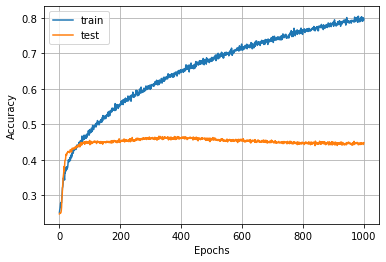

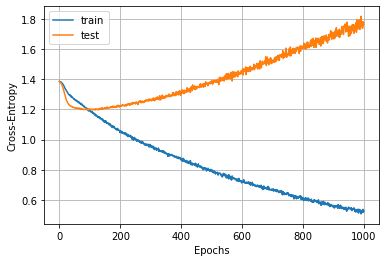

Iteration: 2
Epoch 1/1000
 - 2s - loss: 1.3851 - accuracy: 0.2492 - val_loss: 1.3806 - val_accuracy: 0.2627
Epoch 2/1000
 - 2s - loss: 1.3840 - accuracy: 0.2548 - val_loss: 1.3783 - val_accuracy: 0.2649
Epoch 3/1000
 - 2s - loss: 1.3831 - accuracy: 0.2574 - val_loss: 1.3762 - val_accuracy: 0.2756
Epoch 4/1000
 - 2s - loss: 1.3822 - accuracy: 0.2545 - val_loss: 1.3736 - val_accuracy: 0.2731
Epoch 5/1000
 - 2s - loss: 1.3807 - accuracy: 0.2738 - val_loss: 1.3707 - val_accuracy: 0.2703
Epoch 6/1000
 - 2s - loss: 1.3795 - accuracy: 0.2657 - val_loss: 1.3672 - val_accuracy: 0.2674
Epoch 7/1000
 - 2s - loss: 1.3777 - accuracy: 0.2791 - val_loss: 1.3636 - val_accuracy: 0.2832
Epoch 8/1000
 - 2s - loss: 1.3757 - accuracy: 0.2788 - val_loss: 1.3590 - val_accuracy: 0.2908
Epoch 9/1000
 - 2s - loss: 1.3741 - accuracy: 0.2869 - val_loss: 1.3541 - val_accuracy: 0.2971
Epoch 10/1000
 - 2s - loss: 1.3704 - accuracy: 0.3080 - val_loss: 1.3484 - val_accuracy: 0.3123
Epoch 11/1000
 - 2s - loss: 1.3689 -

Epoch 87/1000
 - 2s - loss: 1.1793 - accuracy: 0.4874 - val_loss: 1.2077 - val_accuracy: 0.4392
Epoch 88/1000
 - 2s - loss: 1.1724 - accuracy: 0.4917 - val_loss: 1.2057 - val_accuracy: 0.4365
Epoch 89/1000
 - 2s - loss: 1.1816 - accuracy: 0.4798 - val_loss: 1.2071 - val_accuracy: 0.4380
Epoch 90/1000
 - 1s - loss: 1.1739 - accuracy: 0.4874 - val_loss: 1.2076 - val_accuracy: 0.4383
Epoch 91/1000
 - 2s - loss: 1.1726 - accuracy: 0.4874 - val_loss: 1.2065 - val_accuracy: 0.4378
Epoch 92/1000
 - 2s - loss: 1.1708 - accuracy: 0.4876 - val_loss: 1.2055 - val_accuracy: 0.4400
Epoch 93/1000
 - 2s - loss: 1.1675 - accuracy: 0.4907 - val_loss: 1.2038 - val_accuracy: 0.4418
Epoch 94/1000
 - 2s - loss: 1.1684 - accuracy: 0.4927 - val_loss: 1.2059 - val_accuracy: 0.4398
Epoch 95/1000
 - 2s - loss: 1.1640 - accuracy: 0.5000 - val_loss: 1.2045 - val_accuracy: 0.4420
Epoch 96/1000
 - 2s - loss: 1.1654 - accuracy: 0.4914 - val_loss: 1.2077 - val_accuracy: 0.4365
Epoch 97/1000
 - 2s - loss: 1.1639 - acc

Epoch 172/1000
 - 2s - loss: 1.0550 - accuracy: 0.5620 - val_loss: 1.2050 - val_accuracy: 0.4560
Epoch 173/1000
 - 2s - loss: 1.0499 - accuracy: 0.5565 - val_loss: 1.2054 - val_accuracy: 0.4577
Epoch 174/1000
 - 2s - loss: 1.0530 - accuracy: 0.5529 - val_loss: 1.2027 - val_accuracy: 0.4605
Epoch 175/1000
 - 2s - loss: 1.0550 - accuracy: 0.5577 - val_loss: 1.2103 - val_accuracy: 0.4522
Epoch 176/1000
 - 2s - loss: 1.0404 - accuracy: 0.5597 - val_loss: 1.2136 - val_accuracy: 0.4573
Epoch 177/1000
 - 2s - loss: 1.0503 - accuracy: 0.5604 - val_loss: 1.2046 - val_accuracy: 0.4560
Epoch 178/1000
 - 2s - loss: 1.0467 - accuracy: 0.5615 - val_loss: 1.2066 - val_accuracy: 0.4585
Epoch 179/1000
 - 2s - loss: 1.0485 - accuracy: 0.5620 - val_loss: 1.2056 - val_accuracy: 0.4535
Epoch 180/1000
 - 2s - loss: 1.0423 - accuracy: 0.5716 - val_loss: 1.2092 - val_accuracy: 0.4600
Epoch 181/1000
 - 2s - loss: 1.0493 - accuracy: 0.5549 - val_loss: 1.2044 - val_accuracy: 0.4567
Epoch 182/1000
 - 2s - loss: 1

Epoch 257/1000
 - 2s - loss: 0.9550 - accuracy: 0.6086 - val_loss: 1.2287 - val_accuracy: 0.4613
Epoch 258/1000
 - 2s - loss: 0.9578 - accuracy: 0.6047 - val_loss: 1.2327 - val_accuracy: 0.4626
Epoch 259/1000
 - 2s - loss: 0.9600 - accuracy: 0.6023 - val_loss: 1.2307 - val_accuracy: 0.4630
Epoch 260/1000
 - 2s - loss: 0.9506 - accuracy: 0.6103 - val_loss: 1.2467 - val_accuracy: 0.4565
Epoch 261/1000
 - 2s - loss: 0.9572 - accuracy: 0.6068 - val_loss: 1.2365 - val_accuracy: 0.4573
Epoch 262/1000
 - 2s - loss: 0.9545 - accuracy: 0.6080 - val_loss: 1.2305 - val_accuracy: 0.4603
Epoch 263/1000
 - 2s - loss: 0.9503 - accuracy: 0.6068 - val_loss: 1.2299 - val_accuracy: 0.4613
Epoch 264/1000
 - 2s - loss: 0.9479 - accuracy: 0.6141 - val_loss: 1.2283 - val_accuracy: 0.4611
Epoch 265/1000
 - 2s - loss: 0.9551 - accuracy: 0.6128 - val_loss: 1.2311 - val_accuracy: 0.4633
Epoch 266/1000
 - 2s - loss: 0.9592 - accuracy: 0.6032 - val_loss: 1.2346 - val_accuracy: 0.4630
Epoch 267/1000
 - 2s - loss: 0

Epoch 342/1000
 - 2s - loss: 0.8734 - accuracy: 0.6460 - val_loss: 1.2796 - val_accuracy: 0.4608
Epoch 343/1000
 - 1s - loss: 0.8877 - accuracy: 0.6448 - val_loss: 1.2719 - val_accuracy: 0.4583
Epoch 344/1000
 - 2s - loss: 0.8762 - accuracy: 0.6445 - val_loss: 1.2682 - val_accuracy: 0.4593
Epoch 345/1000
 - 2s - loss: 0.8767 - accuracy: 0.6453 - val_loss: 1.2767 - val_accuracy: 0.4590
Epoch 346/1000
 - 2s - loss: 0.8908 - accuracy: 0.6369 - val_loss: 1.2629 - val_accuracy: 0.4565
Epoch 347/1000
 - 2s - loss: 0.8898 - accuracy: 0.6440 - val_loss: 1.2755 - val_accuracy: 0.4592
Epoch 348/1000
 - 2s - loss: 0.8873 - accuracy: 0.6501 - val_loss: 1.2668 - val_accuracy: 0.4613
Epoch 349/1000
 - 2s - loss: 0.8846 - accuracy: 0.6362 - val_loss: 1.2710 - val_accuracy: 0.4608
Epoch 350/1000
 - 2s - loss: 0.8725 - accuracy: 0.6424 - val_loss: 1.2846 - val_accuracy: 0.4633
Epoch 351/1000
 - 2s - loss: 0.8746 - accuracy: 0.6448 - val_loss: 1.2683 - val_accuracy: 0.4618
Epoch 352/1000
 - 2s - loss: 0

Epoch 427/1000
 - 2s - loss: 0.8161 - accuracy: 0.6782 - val_loss: 1.3328 - val_accuracy: 0.4542
Epoch 428/1000
 - 2s - loss: 0.8135 - accuracy: 0.6777 - val_loss: 1.3230 - val_accuracy: 0.4573
Epoch 429/1000
 - 2s - loss: 0.8299 - accuracy: 0.6612 - val_loss: 1.3238 - val_accuracy: 0.4549
Epoch 430/1000
 - 2s - loss: 0.8158 - accuracy: 0.6776 - val_loss: 1.3247 - val_accuracy: 0.4532
Epoch 431/1000
 - 2s - loss: 0.8191 - accuracy: 0.6653 - val_loss: 1.3236 - val_accuracy: 0.4578
Epoch 432/1000
 - 2s - loss: 0.8151 - accuracy: 0.6675 - val_loss: 1.3219 - val_accuracy: 0.4532
Epoch 433/1000
 - 2s - loss: 0.8117 - accuracy: 0.6749 - val_loss: 1.3324 - val_accuracy: 0.4532
Epoch 434/1000
 - 2s - loss: 0.8154 - accuracy: 0.6713 - val_loss: 1.3314 - val_accuracy: 0.4549
Epoch 435/1000
 - 2s - loss: 0.8094 - accuracy: 0.6759 - val_loss: 1.3322 - val_accuracy: 0.4587
Epoch 436/1000
 - 2s - loss: 0.8012 - accuracy: 0.6748 - val_loss: 1.3260 - val_accuracy: 0.4544
Epoch 437/1000
 - 2s - loss: 0

Epoch 512/1000
 - 2s - loss: 0.7546 - accuracy: 0.7040 - val_loss: 1.3867 - val_accuracy: 0.4484
Epoch 513/1000
 - 2s - loss: 0.7531 - accuracy: 0.6989 - val_loss: 1.3720 - val_accuracy: 0.4499
Epoch 514/1000
 - 2s - loss: 0.7593 - accuracy: 0.6961 - val_loss: 1.3835 - val_accuracy: 0.4494
Epoch 515/1000
 - 2s - loss: 0.7558 - accuracy: 0.7004 - val_loss: 1.3809 - val_accuracy: 0.4482
Epoch 516/1000
 - 2s - loss: 0.7575 - accuracy: 0.7019 - val_loss: 1.3890 - val_accuracy: 0.4459
Epoch 517/1000
 - 2s - loss: 0.7546 - accuracy: 0.7006 - val_loss: 1.3865 - val_accuracy: 0.4482
Epoch 518/1000
 - 2s - loss: 0.7610 - accuracy: 0.7017 - val_loss: 1.3988 - val_accuracy: 0.4441
Epoch 519/1000
 - 2s - loss: 0.7533 - accuracy: 0.7011 - val_loss: 1.4014 - val_accuracy: 0.4504
Epoch 520/1000
 - 2s - loss: 0.7512 - accuracy: 0.7027 - val_loss: 1.3752 - val_accuracy: 0.4491
Epoch 521/1000
 - 2s - loss: 0.7433 - accuracy: 0.7009 - val_loss: 1.3912 - val_accuracy: 0.4494
Epoch 522/1000
 - 2s - loss: 0

Epoch 597/1000
 - 2s - loss: 0.7049 - accuracy: 0.7293 - val_loss: 1.4342 - val_accuracy: 0.4479
Epoch 598/1000
 - 2s - loss: 0.7029 - accuracy: 0.7216 - val_loss: 1.4586 - val_accuracy: 0.4473
Epoch 599/1000
 - 2s - loss: 0.7091 - accuracy: 0.7211 - val_loss: 1.4361 - val_accuracy: 0.4456
Epoch 600/1000
 - 2s - loss: 0.7045 - accuracy: 0.7292 - val_loss: 1.4542 - val_accuracy: 0.4421
Epoch 601/1000
 - 2s - loss: 0.6958 - accuracy: 0.7297 - val_loss: 1.4348 - val_accuracy: 0.4463
Epoch 602/1000
 - 2s - loss: 0.6947 - accuracy: 0.7262 - val_loss: 1.4575 - val_accuracy: 0.4478
Epoch 603/1000
 - 2s - loss: 0.6922 - accuracy: 0.7330 - val_loss: 1.4392 - val_accuracy: 0.4433
Epoch 604/1000
 - 2s - loss: 0.6990 - accuracy: 0.7278 - val_loss: 1.4229 - val_accuracy: 0.4444
Epoch 605/1000
 - 2s - loss: 0.6886 - accuracy: 0.7305 - val_loss: 1.4650 - val_accuracy: 0.4454
Epoch 606/1000
 - 1s - loss: 0.6911 - accuracy: 0.7300 - val_loss: 1.4555 - val_accuracy: 0.4415
Epoch 607/1000
 - 2s - loss: 0

Epoch 682/1000
 - 2s - loss: 0.6510 - accuracy: 0.7477 - val_loss: 1.5094 - val_accuracy: 0.4438
Epoch 683/1000
 - 2s - loss: 0.6480 - accuracy: 0.7523 - val_loss: 1.4886 - val_accuracy: 0.4448
Epoch 684/1000
 - 2s - loss: 0.6431 - accuracy: 0.7488 - val_loss: 1.5064 - val_accuracy: 0.4466
Epoch 685/1000
 - 2s - loss: 0.6542 - accuracy: 0.7429 - val_loss: 1.5145 - val_accuracy: 0.4486
Epoch 686/1000
 - 2s - loss: 0.6513 - accuracy: 0.7434 - val_loss: 1.5334 - val_accuracy: 0.4453
Epoch 687/1000
 - 2s - loss: 0.6419 - accuracy: 0.7530 - val_loss: 1.5052 - val_accuracy: 0.4458
Epoch 688/1000
 - 2s - loss: 0.6561 - accuracy: 0.7412 - val_loss: 1.4941 - val_accuracy: 0.4481
Epoch 689/1000
 - 2s - loss: 0.6391 - accuracy: 0.7523 - val_loss: 1.5378 - val_accuracy: 0.4453
Epoch 690/1000
 - 2s - loss: 0.6432 - accuracy: 0.7492 - val_loss: 1.5140 - val_accuracy: 0.4425
Epoch 691/1000
 - 2s - loss: 0.6417 - accuracy: 0.7555 - val_loss: 1.5025 - val_accuracy: 0.4476
Epoch 692/1000
 - 2s - loss: 0

Epoch 767/1000
 - 2s - loss: 0.6005 - accuracy: 0.7688 - val_loss: 1.5619 - val_accuracy: 0.4496
Epoch 768/1000
 - 2s - loss: 0.6083 - accuracy: 0.7659 - val_loss: 1.5868 - val_accuracy: 0.4466
Epoch 769/1000
 - 2s - loss: 0.6063 - accuracy: 0.7647 - val_loss: 1.5890 - val_accuracy: 0.4444
Epoch 770/1000
 - 2s - loss: 0.6027 - accuracy: 0.7730 - val_loss: 1.5697 - val_accuracy: 0.4410
Epoch 771/1000
 - 2s - loss: 0.6080 - accuracy: 0.7697 - val_loss: 1.5745 - val_accuracy: 0.4423
Epoch 772/1000
 - 2s - loss: 0.6074 - accuracy: 0.7655 - val_loss: 1.5725 - val_accuracy: 0.4451
Epoch 773/1000
 - 2s - loss: 0.6136 - accuracy: 0.7659 - val_loss: 1.5755 - val_accuracy: 0.4433
Epoch 774/1000
 - 2s - loss: 0.6090 - accuracy: 0.7650 - val_loss: 1.5623 - val_accuracy: 0.4446
Epoch 775/1000
 - 2s - loss: 0.5936 - accuracy: 0.7707 - val_loss: 1.5802 - val_accuracy: 0.4497
Epoch 776/1000
 - 2s - loss: 0.6018 - accuracy: 0.7669 - val_loss: 1.5742 - val_accuracy: 0.4497
Epoch 777/1000
 - 2s - loss: 0

Epoch 852/1000
 - 2s - loss: 0.5643 - accuracy: 0.7821 - val_loss: 1.6262 - val_accuracy: 0.4484
Epoch 853/1000
 - 2s - loss: 0.5596 - accuracy: 0.7809 - val_loss: 1.6491 - val_accuracy: 0.4411
Epoch 854/1000
 - 2s - loss: 0.5655 - accuracy: 0.7846 - val_loss: 1.6074 - val_accuracy: 0.4487
Epoch 855/1000
 - 2s - loss: 0.5682 - accuracy: 0.7788 - val_loss: 1.6755 - val_accuracy: 0.4428
Epoch 856/1000
 - 2s - loss: 0.5644 - accuracy: 0.7796 - val_loss: 1.6456 - val_accuracy: 0.4428
Epoch 857/1000
 - 2s - loss: 0.5669 - accuracy: 0.7791 - val_loss: 1.6458 - val_accuracy: 0.4499
Epoch 858/1000
 - 2s - loss: 0.5668 - accuracy: 0.7784 - val_loss: 1.6348 - val_accuracy: 0.4430
Epoch 859/1000
 - 2s - loss: 0.5714 - accuracy: 0.7731 - val_loss: 1.6489 - val_accuracy: 0.4469
Epoch 860/1000
 - 2s - loss: 0.5447 - accuracy: 0.7961 - val_loss: 1.6651 - val_accuracy: 0.4420
Epoch 861/1000
 - 2s - loss: 0.5630 - accuracy: 0.7844 - val_loss: 1.6457 - val_accuracy: 0.4439
Epoch 862/1000
 - 2s - loss: 0

Epoch 937/1000
 - 2s - loss: 0.5264 - accuracy: 0.7953 - val_loss: 1.7112 - val_accuracy: 0.4436
Epoch 938/1000
 - 2s - loss: 0.5261 - accuracy: 0.7996 - val_loss: 1.7148 - val_accuracy: 0.4492
Epoch 939/1000
 - 2s - loss: 0.5121 - accuracy: 0.8044 - val_loss: 1.7214 - val_accuracy: 0.4458
Epoch 940/1000
 - 2s - loss: 0.5232 - accuracy: 0.7998 - val_loss: 1.7146 - val_accuracy: 0.4476
Epoch 941/1000
 - 2s - loss: 0.5226 - accuracy: 0.7983 - val_loss: 1.6996 - val_accuracy: 0.4464
Epoch 942/1000
 - 2s - loss: 0.5282 - accuracy: 0.7993 - val_loss: 1.7676 - val_accuracy: 0.4466
Epoch 943/1000
 - 2s - loss: 0.5335 - accuracy: 0.7918 - val_loss: 1.7177 - val_accuracy: 0.4444
Epoch 944/1000
 - 2s - loss: 0.5286 - accuracy: 0.7963 - val_loss: 1.7176 - val_accuracy: 0.4471
Epoch 945/1000
 - 2s - loss: 0.5184 - accuracy: 0.8004 - val_loss: 1.7226 - val_accuracy: 0.4471
Epoch 946/1000
 - 2s - loss: 0.5148 - accuracy: 0.8004 - val_loss: 1.7356 - val_accuracy: 0.4497
Epoch 947/1000
 - 2s - loss: 0

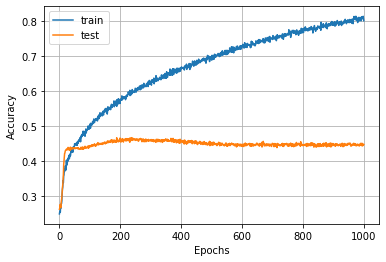

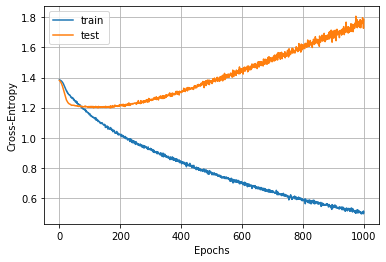


Resultados:
loss: [1.7626809825499852, 1.7843978108946608]
accuracy: [0.44841268658638, 0.44708994030952454]
kappa: [0.26455026455026454, 0.2627865961199295]
Tiempo: 3967.359872341156


In [20]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=512),
                                steps_per_epoch=np.ceil(n_samples_train/512),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
print("Tiempo:", fin - inicio)

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 264, 4, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 132, 2, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 132, 2, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 66, 1, 16)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                67648     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

In [23]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4478
std: (+/- 0.0007)
Mean Kappa: 0.2637
std: (+/- 0.0009)
Max Accuracy: 0.4484
Max Kappa: 0.2646
